# Lyrics search engine design

# Introduction

This project deals with the implementation of retrieval models that can identify the correct song title when given a song’s lyrics, or part of the lyrics, as our query. The scope of this project is to carry out the tasks of indexing, ranking and retrieving, finding how different information retrieval models are able to rank the relevant documents, using different evaluation criteria for the results as well as creating an input interface for the user. As our data, a Kaggle lyrics dataset is used, containing a total of 79 musical genres across multiple languages.

The Python programming language is used for this project, via a Jupyter notebook on Google Colab. The main Python libraries and tools used for this project are PyLucene, PyLucene, Elasticsearch, NLTK, spaCy and WordNet.


The various components in the model can be broken down into the following:


* Data Loader: To load and convert the benchmark Lyric dataset into a workable structure for cleaning, pre-processing and indexing.

* Cleaning Framework: Python NLTK and spaCy packages will be used to clean and pre- process the dataset. The lyric text will be tokenized into words first and techniques such as lowercasing, removal of punctuations, Snowball/Porter Stemming, Lemmatization and removal of stopwords using WordNet will be applied on the tokens. Manual cleaning and use of synsets package is also necessary to take care of the slang terms in the lyrics.

* Indexing Framework: For each of the tokens, inverted indices will be computed.

* Query Processor Framework: The cleaning and indexing steps will be performed for the queries like on the dataset.

* Retrieval Framework: After the query processing is completed, retrieval models will be applied and compared. It will contain the BM25 and Vector Space Model implementations. PyLucene will be used to compute the relevance of each document to the query.

* Evaluation Framework: The search results are evaluated on the basis of multiple metrics including Precision (amount of retrieved plots that are actually relevant to the query) Recall (amount of relevant songs retrieved), MAP (Mean Average Precision), F-measure (Harmonic Mean of Precision and Recall) and MRR (Mean Reciprocal Rank@K - a metric which considers only the position of the first relevant document returned in the first K documents for each query).

Below an architectural diagram of the project is shown:


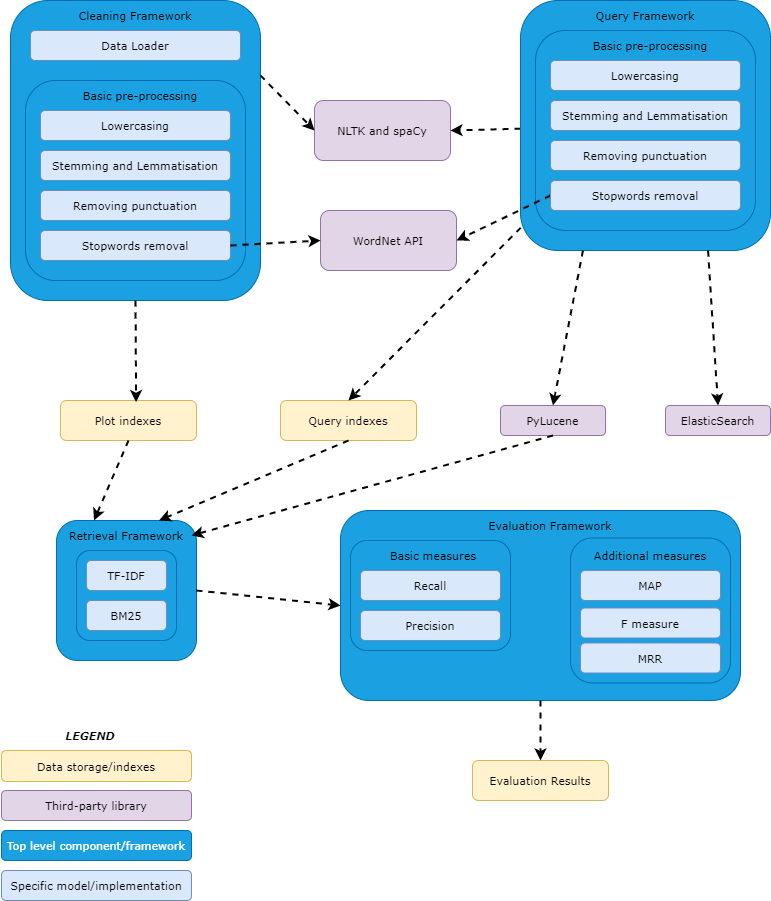

## Data pre-processing

**Dependencies and setup**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
STOP_WORDS = set(stopwords.words('english'))
import math
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import spacy
from spacy import displacy
from scipy.sparse import lil_matrix
import seaborn as sns; sns.set();
from numpy.linalg import norm
from scipy.linalg import svd
import os
from sklearn.feature_extraction.text import CountVectorizer
nlp = spacy.load('en_core_web_sm')  
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
!wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
!tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
!sudo chown -R daemon:daemon elasticsearch-7.9.2/
!shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


In [ ]:
!pip install elasticsearch==7.9.1 -q

In [ ]:
import urllib.request 
from bs4 import BeautifulSoup 
import re
import time
import random
from elasticsearch import Elasticsearch

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

In [ ]:
# Sleep for few seconds to let the instance start.
time.sleep(20)

In [ ]:
%%bash

ps -ef | grep elasticsearch

root        2154    2148  0 16:45 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon      2155    2154  6 16:45 ?        00:00:47 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-18336636846051493285 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:fileco

In [ ]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "f00eb2a7d87b",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "XNVswR-uRp2_bLeiO-59sw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
def test_ES(es):
  return es.ping()  

es = Elasticsearch("http://localhost:9200")
if test_ES(es):
  print('ES instance working')
else:
  print('ES instance not working')

es.info()

ES instance working


{'name': 'f00eb2a7d87b',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'XNVswR-uRp2_bLeiO-59sw',
 'version': {'number': '7.9.2',
  'build_flavor': 'oss',
  'build_type': 'tar',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

**Data Setup**

In [ ]:
#Dataset sourced from https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres
df_artists=pd.read_csv('artists-data.csv')
df_artists

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/
...,...,...,...,...,...
4163,Miriam Makeba,World Music; Black Music; Blues,17.0,0.0,/miriam-makeba/
4164,Freddie Aguilar,World Music,61.0,0.0,/freddie-aguilar/
4165,Amadou & Mariam,World Music,14.0,0.0,/amadou-mariam/
4166,Magic System,World Music; Gospel/Religioso,16.0,0.0,/magic-system/


In [ ]:
df_lyrics=pd.read_csv('lyrics-data.csv')
df_lyrics

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [ ]:
df_lyrics=df_lyrics.loc[df_lyrics.language=='en'].reset_index()
df_lyrics

,index,ALink,SName,SLink,Lyric,language
0,69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
1,86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
2,88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
3,111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
4,140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en
...,...,...,...,...,...,...
191809,379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
191810,379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
191811,379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
191812,379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [ ]:
#Check for missing rows
missing=df_lyrics.loc[df_lyrics.isnull().any(axis=1)]
print('Rows with missing data: {}'.format(missing.shape[0]))
print('Percentage of rows with missing data: {:.3f}%'.format(missing.shape[0]/df_lyrics.shape[0]*100))
df_lyrics.dropna()

Rows with missing data: 2
Percentage of rows with missing data: 0.001%


,index,ALink,SName,SLink,Lyric,language
0,69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
1,86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
2,88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
3,111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
4,140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en
...,...,...,...,...,...,...
191809,379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
191810,379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
191811,379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
191812,379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [ ]:
#Get column with artists' names
artists_dict=dict(zip(df_artists.Link,df_artists.Artist))

In [ ]:
def Artists_function(row):
    if row.ALink in artists_dict:
         return artists_dict[row.ALink]
    return
    
df_lyrics = df_lyrics.assign(Actual_Artist_Name = df_lyrics.apply(Artists_function, axis=1))
df_lyrics

,index,ALink,SName,SLink,Lyric,language,Actual_Artist_Name
0,69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en,Ivete Sangalo
1,86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en,Ivete Sangalo
2,88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en,Ivete Sangalo
3,111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en,Ivete Sangalo
4,140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en,Ivete Sangalo
...,...,...,...,...,...,...,...
191809,379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en,Johnny Clegg
191810,379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en,Johnny Clegg
191811,379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en,Johnny Clegg
191812,379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en,Johnny Clegg


In [ ]:
#Delete useless columns
df_lyrics = df_lyrics.drop(columns=['index', 'ALink', 'SLink', 'language'])
df_lyrics

,SName,Lyric,Actual_Artist_Name
0,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,Ivete Sangalo
1,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",Ivete Sangalo
2,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",Ivete Sangalo
3,Easy,"Know it sounds funny\nBut, I just can't stand ...",Ivete Sangalo
4,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,Ivete Sangalo
...,...,...,...
191809,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,Johnny Clegg
191810,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,Johnny Clegg
191811,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",Johnny Clegg
191812,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,Johnny Clegg


In [ ]:
#Replace \n with space in lyrics
df_lyrics.Lyric=df_lyrics.Lyric.replace(r'\n',' ', regex=True)  

In [ ]:
df_lyrics_small=df_lyrics[0:1000]
df_lyrics_small

,SName,Lyric,Actual_Artist_Name
0,Careless Whisper,I feel so unsure As I take your hand and lead ...,Ivete Sangalo
1,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya Or even try to school,...",Ivete Sangalo
2,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here Don't be co...",Ivete Sangalo
3,Easy,"Know it sounds funny But, I just can't stand t...",Ivete Sangalo
4,For Your Babies (The Voice cover),You've got that look again The one I hoped I h...,Ivete Sangalo
...,...,...,...
995,Realest Niggas,[Intro] (50 Cent) I love niggas! I love niggas...,50 Cent
996,Realest Niggas (ft. Notorious B.i.g.),[Intro] (50 Cent) I love niggas! I love niggas...,50 Cent
997,Realest Niggas (remix),[Intro] (50 Cent) I love niggas! I love niggas...,50 Cent
998,Redrum (murder),"No it don't fuckin matter, we gonna do it my w...",50 Cent


**Pre-Processing**

In [ ]:
def clean_text(text):
    
    """Given a text, return the same text without words smaller than two letters, numbersd and punctuation. 
    Apply also stemming on the words of the text"""
    
    text = ' '.join([c.lower() for c in str(text).split() if len(c)>2])
    numbers_patterns = re.compile('[0-9]+[\w]*')
    text = re.sub(numbers_patterns, '', text)
    punctiation_pattern = re.compile('[!-_@#$%^''&*()?`<>;\.,:"]')
    text = re.sub(punctiation_pattern, '', text)
    text = ' '.join(porter.stem(word) for word in text.split()) 
    return text

In [ ]:
documents =[]
for a in df_lyrics_small['Lyric']:
  documents.append(clean_text(a))

In [ ]:
df_lyrics_small = df_lyrics_small.assign(Lyric_cleaned=documents)
df_lyrics_small

,SName,Lyric,Actual_Artist_Name,Lyric_cleaned
0,Careless Whisper,I feel so unsure As I take your hand and lead ...,Ivete Sangalo,feel unsur take your hand and lead you the dan...
1,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya Or even try to school,...",Ivete Sangalo,dont let them fool even tri school ya oh no we...
2,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here Don't be co...",Ivete Sangalo,babi let cruis away from here dont confus the ...
3,Easy,"Know it sounds funny But, I just can't stand t...",Ivete Sangalo,know sound funni but just cant stand the pain ...
4,For Your Babies (The Voice cover),You've got that look again The one I hoped I h...,Ivete Sangalo,youv got that look again the one hope had when...
...,...,...,...,...
995,Realest Niggas,[Intro] (50 Cent) I love niggas! I love niggas...,50 Cent,intro cent love nigga love nigga caus nigga ar...
996,Realest Niggas (ft. Notorious B.i.g.),[Intro] (50 Cent) I love niggas! I love niggas...,50 Cent,intro cent love nigga love nigga caus nigga ar...
997,Realest Niggas (remix),[Intro] (50 Cent) I love niggas! I love niggas...,50 Cent,intro cent love nigga love nigga caus nigga ar...
998,Redrum (murder),"No it don't fuckin matter, we gonna do it my w...",50 Cent,dont fuckin matter gonna way from here now it ...


## Query framework implementation

**Elastic Search Implementation**

In [ ]:
def get_lyrics_data():
  lyrics_data = df_lyrics_small.to_records(index=False)
  return lyrics_data


In [ ]:
def clean_corpus(corpus):
  song = [x[0] for x in corpus]
  sLyrics = [x[1]for x in corpus]
  sArtist = [x[2] for x in corpus]
  doc_ids = list(range(len(song)))
  print(doc_ids)
  return list(zip(doc_ids, song, sLyrics, sArtist))

In [ ]:
corpus = get_lyrics_data()
corpus = clean_corpus(corpus)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
request_body = {
    'settings': {
        'number_of_shards': 1,
        'number_of_replicas': 1,
        
    },
    'mappings': {
          'properties': {
              'doc_id': {'type': 'integer'},
              'song': {'type': 'text'},
              'sLyrics': {'type': 'text'},
              'sArtist': {'type': 'text'}

          }
    }
}

index_name = 'test'
try:
  es.indices.get(index_name)
  print('index {} already exists'.format(index_name))
except:
  print('creating index {}'.format(index_name))
  es.indices.create(index_name, body=request_body)

creating index test


In [ ]:
for doc_id, song, sLyrics, sArtist in corpus:
  doc_body = {
      'doc_id': doc_id,
      'song': song,
      'sLyrics': sLyrics,
      'sArtist': sArtist
  }
  es.index(index_name, doc_body)

In [ ]:
def index_info(index_name):
  count, deleted, shards, =  es.cat.indices(index=index_name, h=['docs.count', 'docs.deleted', 'pri'])[:-1].split(' ')
  print(
      """
      #### INDEX INFO #####
      index_name = {}
      doc_count = {}
      shard_count = {}
      deleted_doc_count = {}
      """.format(index_name, count, shards, deleted)
  )
  
index_info(index_name)


      #### INDEX INFO #####
      index_name = test
      doc_count = 970
      shard_count = 1
      deleted_doc_count = 0
      


In [ ]:
def search(index_name, query_body):
  results = es.search(index=index_name, body=query_body, explain=False)
  plain_results = [(x['_source']['doc_id'], x['_source']['song'], x['_source']['sArtist'], x['_score']) for x in results['hits']['hits']]
  return results, plain_results

## User interface implementation

In [ ]:
#@title Please enter your query
query = 'dance floor'  #@param {type:"string"}

query_terms = query.split(' ')

query_body = {
    'query':{
        'match': {
            'sLyrics':  query
        }
    }
}
results, plain_results = search(index_name, query_body)
for doc_id, title, year, score in plain_results:
  print(doc_id, title, year, score)

971 Outta Control 50 Cent 9.043854
145 Get Me Bodied Remix (extended Version) Beyoncé 8.90977
654 Who's That Chick Rihanna 8.568014
269 Telephone Beyoncé 8.437828
193 Move Your Body Beyoncé 8.337978
0 Careless Whisper Ivete Sangalo 8.140784
321 Versace On The Floor Bruno Mars 7.983289
409 Versace On The Floor (David Guetta Remix) Bruno Mars 7.9239564
637 Vogue Rihanna 7.6681247
780 Disco Inferno 50 Cent 7.5306625


## Indexing, retrieval and evaluation frameworks

**Indexing**

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(documents)
vocabulary = vectorizer.get_feature_names_out()

In [ ]:
dataframe = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
dataframe

,aa,aaaaaaaay,aaaaaaahhhhhhhh,aaaaaah,aaaaah,aaaaahhhooooooohhh,aaaaass,aaah,aah,aahh,...,zung,zz,àquel,âaww,âem,âoh,ça,éléveron,ɲi,еm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dfs = (dataframe > 0).sum(axis=0)
N = dataframe.shape[0]
idfs = np.log10(N/dfs)

**Retrieval**

**BM25 Implementation**

In [ ]:
k_1 = 1.2 # single value
b = 0.8 # single value
## considering all words in doc
dls = [len(d.split(' ')) for d in documents] # vector
dls = dataframe.sum(axis=1).tolist()
avgdl = np.mean(dls) # single value

In [ ]:
numerator = np.array((k_1 + 1) * dataframe)
denominator = np.array(k_1 *((1 - b) + b * (dls / avgdl))).reshape(N,1) + np.array(dataframe)

BM25_tf = numerator / denominator

idfs = np.array(idfs)

BM25_score = BM25_tf * idfs

In [ ]:
bm25_idf = pd.DataFrame(BM25_score, columns=vocabulary)


In [ ]:
q_terms = clean_text(query).split()
q_terms
q_terms_only_df = bm25_idf[q_terms]
score_q_d = q_terms_only_df.sum(axis=1)
BM25_ranked=sorted(zip(documents,score_q_d.values), key = lambda tup:tup[1], reverse=True)


In [ ]:
BM25_ranked[:10]

[('yeah shadi aftermath guess you didnt know back for more everybodi the floor goin goin outta control set off from your left dawg set off from your right dawg set off nigga said set off sick with boy better get wit what the club get goin goin uhh just move the music it the sound and dre everyth calcul time percis never move anoth mill let get right aight success drug choic im high off life feelin lucki enough bet all the dice shorti what you wanna hit the danc floor move how you wanna move later on can cruis you wanna cruis it whatev you want the fact got more than flaunt did thang the club everi chanc get tear danc floor jampack got em goin goin outta control set off from your left dawg set off from your right dawg set off nigga said set off system thumpin danc floor jumpin thirti deep thi bitch stuntin that what you get you hood thought you understood you know me vip bottl dp real big bitch break their neck where take em ecstaci without ecstaci im the chef you need hit got the recip

In [ ]:
BM25_ranked[:10]

**VSM implementation**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import sklearn

In [ ]:
q_terms = [clean_text(query)]
q_terms

['danc floor']

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
q_terms_vectorized = vectorizer.fit_transform(q_terms)

q_terms_df = pd.DataFrame(q_terms_vectorized.toarray())
q_terms_only_df_for_VSM = dataframe[clean_text(query).split()]


In [ ]:
VSM_scores=[]
for i in range(len(dataframe)):
  result=sklearn.metrics.pairwise.cosine_similarity(q_terms_only_df_for_VSM.iloc[[i]], q_terms_df, dense_output=True)
  VSM_scores.append(result)

In [ ]:
VSM_ranked=sorted(zip(documents,VSM_scores), key = lambda tup:tup[1], reverse=True)

In [ ]:
VSM_ranked[:10]

[('certifi qualiti dat the girl them need and them not stop cri without apolog buck dem the right way that polici sean paul alongsid now hear what man say beyoncé dutti ya dutti ya dutti beyonc sing now choru babi boy you stay mind fulfil fantasi think about you all the time see you dream babi boy not day goe without fantasi think about you all the time see you dream ah oh babi fli babi ye no hurt good babi im wrap love let go let breath stay out fantasi sean paul readi gimm ting dat readi get live and tell all about the ting that you will fantas know you dig the way step the way make stride follow your feel babi girl bc they cannot deni come check ina night and make get amplifi have the ting run the ship caus im slip and im slide and the word love got get certifi but give you the toughest longest kinda ride girl choru babi boy you stay mind fulfil fantasi think about you all the time see you dream babi boy not day goe without fantasi think about you all the time see you dream pictur d

In [ ]:
def get_indices_of_top_results(ranked_list):
  top_results=[i[0] for i in ranked_list][:20]
  indices_of_top_results=[]
  z1=df_lyrics_small.Lyric_cleaned.isin(top_results).to_numpy()
  for i in range(len(df_lyrics_small)):
    if z1[i]==True:
      indices_of_top_results.append(i)
  return indices_of_top_results

In [ ]:
VSM_indices_of_top_results=get_indices_of_top_results(VSM_ranked)
BM25_indices_of_top_results=get_indices_of_top_results(BM25_ranked)


**Establishing ground truths using BM25 Okapi standard implementation**

In [ ]:
!pip install rank_bm25
from rank_bm25 import BM25Okapi

In [ ]:
corpus = df_lyrics_small['Lyric']
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

# Process query and get scores for each indexed document using BM25
tokenized_query = query.split(" ")
print('Query ==> ', query)
scores = bm25.get_scores(tokenized_query)
# print(scores, len(scores))

Query ==>  dance floors


**Evaluation**

In [ ]:
def mean_reciprocal_rank(bool_results, k=20):
    bool_results = (np.atleast_1d(r[:k]).nonzero()[0] for r in bool_results)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in bool_results])

In [ ]:
BM25_Okapi_indices_of_top_results=most_relevant_documents[:20]

MRR@20 evaluation for BM25

In [ ]:
most_relevant_documents = np.argsort(-scores)
# rel_docs=[]
# for i in most_relevant_documents[:10]:
#   rel_docs.append(df_lyrics_small['Lyric'][i])
rel_docs = most_relevant_documents[:20]
masked_relevance_results = np.zeros(len(BM25_ranked))
masked_relevance_results[rel_docs] = 1
sorted_masked_relevance_results = np.take(masked_relevance_results, most_relevant_documents)

# print(sorted_masked_relevance_results[:10]) #printing first 20 results: 1 is relevant 0 isn't

# # Calculate MRR@10
# print(mean_reciprocal_rank([sorted_masked_relevance_results]))

MRR@20 evaluation for VSM

In [ ]:
masked_relevance_results_VSM = np.zeros(len(VSM_ranked))
masked_relevance_results_VSM[rel_docs] = 1
sorted_masked_relevance_results_VSM = np.take(masked_relevance_results_VSM, most_relevant_documents)

# print(sorted_masked_relevance_results_VSM[:10]) #printing first 20 results: 1 is relevant 0 isn't

# # Calculate MRR@10
# print(mean_reciprocal_rank([sorted_masked_relevance_results_VSM]))

In [ ]:
def calculate_metrics(indices_of_top_results, BM25_Okapi_indices_of_top_results):
  P=len(BM25_Okapi_indices_of_top_results)
  N=len(df_lyrics_small)-P
  TP=len(set(indices_of_top_results).intersection(BM25_Okapi_indices_of_top_results))
  FP=len(BM25_Okapi_indices_of_top_results)-TP
  FN=P-TP
  TN=N-FP

  accuracy=(TP+TN)/(P+N)
  precision=TP/(TN+FP)
  sensitivity=TP/P
  specificity=TN/N
  F1_score=(2*TP)/(2*TP+FP+FN)


  print("The resulting metrics are:\n")
  print("accuracy= {:.3f}".format(accuracy))
  print("precision= {:.3f}".format(precision))
  print("sensitivity= {:.3f}".format(sensitivity))
  print("specificity= {:.3f}".format(specificity))
  print("F1 score= {:.3f}".format(F1_score))

In [ ]:
print("VSM Results:")
calculate_metrics(VSM_indices_of_top_results, BM25_Okapi_indices_of_top_results)
print("MRR@20 score= {:.3f}".format(mean_reciprocal_rank([sorted_masked_relevance_results_VSM])))

VSM Results:
The resulting metrics are:

accuracy= 0.966
precision= 0.003
sensitivity= 0.150
specificity= 0.983
F1 score= 0.150
MRR@20 score= 1.000


In [ ]:
print("BM25 Results:")
calculate_metrics(BM25_indices_of_top_results, BM25_Okapi_indices_of_top_results)
print("MRR@20 score= {:.3f}".format(mean_reciprocal_rank([sorted_masked_relevance_results])))

BM25 Results:
The resulting metrics are:

accuracy= 0.972
precision= 0.006
sensitivity= 0.300
specificity= 0.986
F1 score= 0.300
MRR@20 score= 1.000
